conda install -c anaconda seaborn=0.7.1

In [5]:
import pandas as pd
import thinkstats2 as ts2
import thinkplot as tp
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import math
import seaborn as sns
from bokeh.io import output_notebook
%matplotlib inline

In [6]:
dataframe = pd.read_csv("dataframe.csv")

In [7]:
dataframe.columns = ['date', 'rain', 'snowdepth', 'snow', 'weekday', 'weekend', 'holidays', 'trips', 'pmt', 'entries']

In [112]:
df = dataframe[dataframe.pmt>0]
mta = dataframe[dataframe.entries>0]

In [195]:
df["date"]=pd.to_datetime(df.date, infer_datetime_format=True)
mta["date"]=pd.to_datetime(mta.date, infer_datetime_format=True)

C:\Users\Jay Price\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Jay Price\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [196]:
class CorrelationPermuate(ts2.HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(ts2.Corr(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

class CovariancePermutate(ts2.HypothesisTest):    
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(ts2.Cov(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
class DiffMeansPermutate(ts2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

## Model the variables.

In [187]:
from bokeh.charts import Histogram, show

hist = Histogram(df, values='pmt', title="Histogram for Passenger Miles Traveled", color='purple', bins=25, plot_width=800)

show(hist)

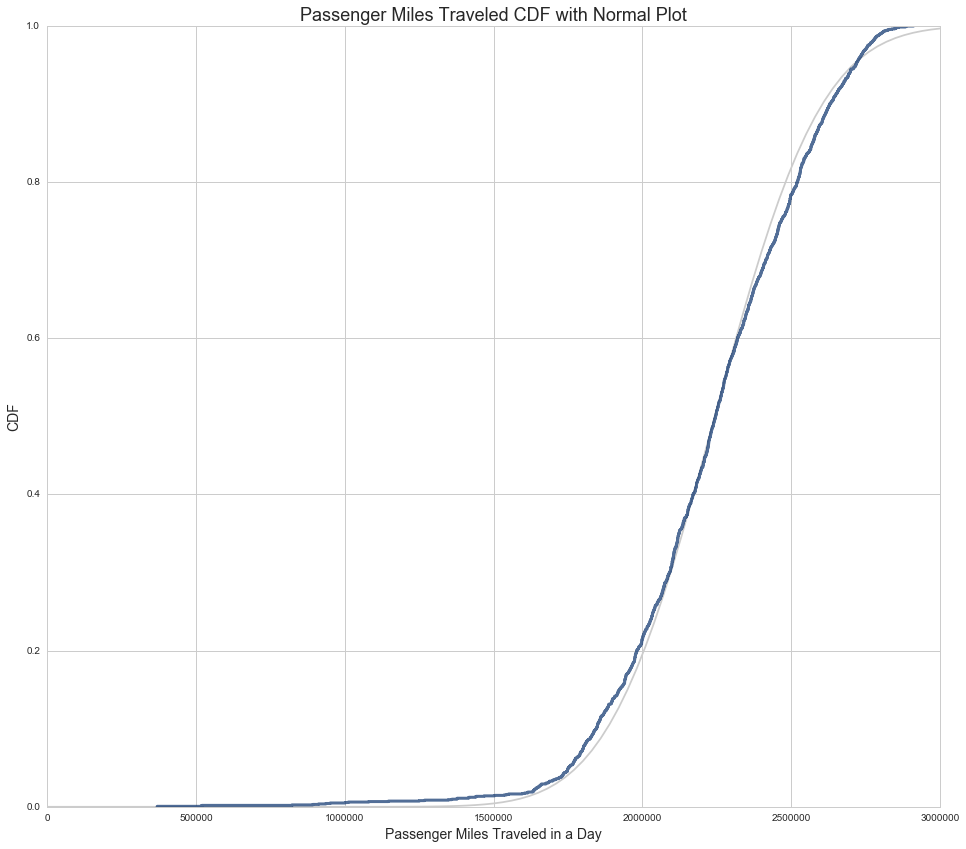

In [75]:
data1 = df.pmt
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderNormalCdf(mu1, sigma1, low=0, high=3000000)
pmt_cdf = ts2.Cdf(data1)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')

#parameters for the resulting graph:
plt.title("Passenger Miles Traveled CDF with Normal Plot", fontsize=18)
plt.xlabel("Passenger Miles Traveled in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(pmt_cdf)
plt.show()

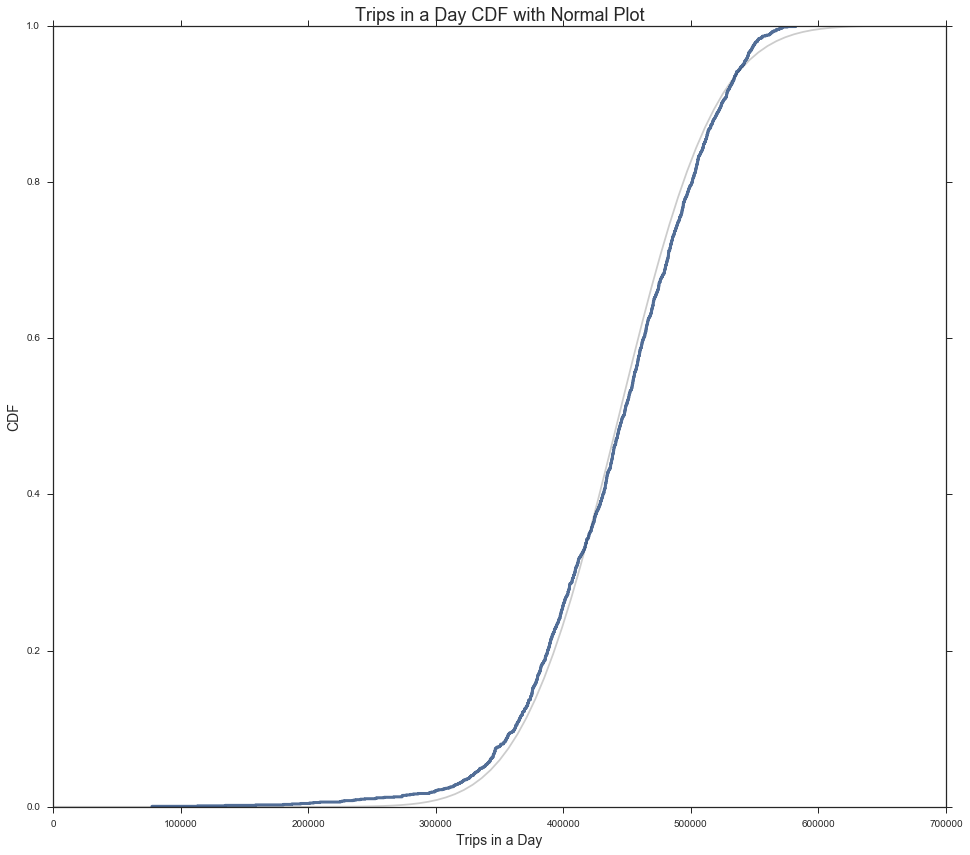

In [217]:
data1 = df.trips
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderNormalCdf(mu1, sigma1, low=0, high=700000)
pmt_cdf = ts2.Cdf(data1)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')

#parameters for the resulting graph:
plt.title("Trips in a Day CDF with Normal Plot", fontsize=18)
plt.xlabel("Trips in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(pmt_cdf)
plt.show()

In [220]:
plt.figure(figsize=(16,14))
rain = df.rain
hist = Histogram(rain, values='rain', title="Rain Histogram", color='blue', bins=30, plot_width=800)

show(hist)

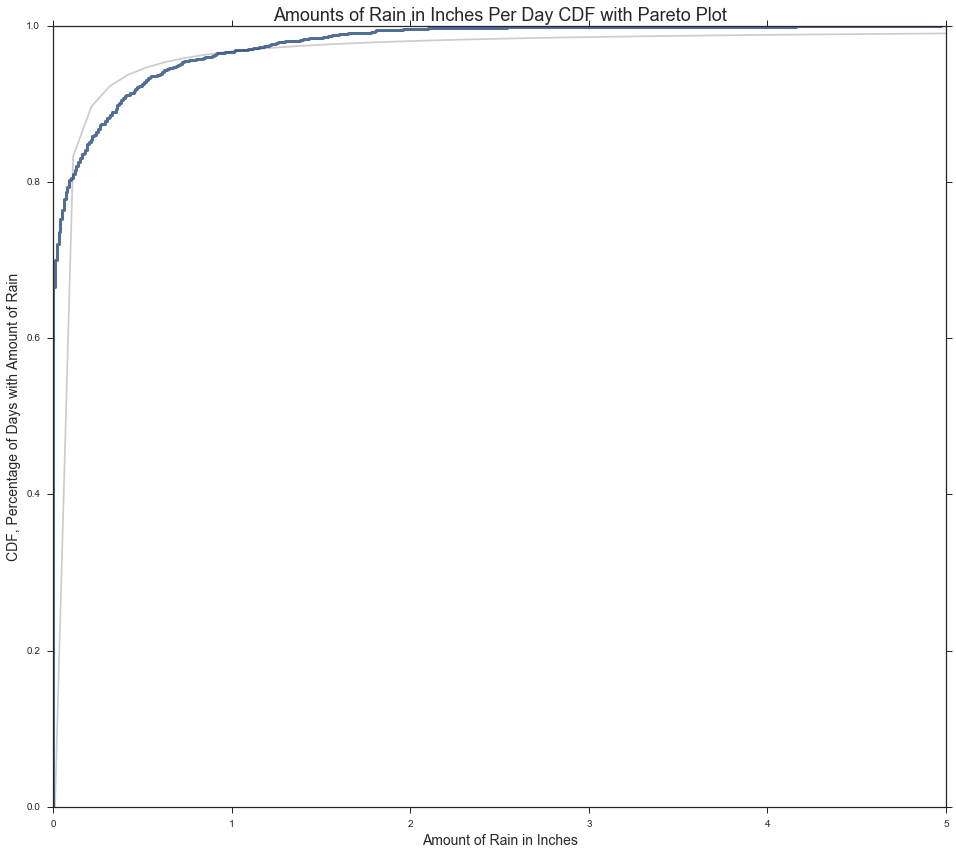

4.97


In [221]:
data1 = df.rain
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)
high = max(df.rain)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderParetoCdf(xmin=0.01, alpha=0.74, low=0, high=5.0)
pmt_cdf = ts2.Cdf(data1)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')

# parameters for the resulting graph:
plt.title("Amounts of Rain in Inches Per Day CDF with Pareto Plot", fontsize=18)
plt.xlabel("Amount of Rain in Inches", fontsize=14)
plt.ylabel("CDF, Percentage of Days with Amount of Rain", fontsize=14)

# plot the data
tp.Cdf(pmt_cdf)
plt.show()
print(high)

# Hypothesis: Rain has some affect on either the number of passenger miles traveled or the number of trips.
### First, by permutation of the two samples, it is possible to check whether this is a statistically significant difference between their means.

In [198]:
rain = df[df.rain>0].pmt
clear = df[df.rain==0].pmt
data = rain, clear
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(rain.mean()-clear.mean())
print(difference_in_means)
print(pvalue)

41553.328787924256
0.011


In [200]:
rain = df[df.rain>0].trips
clear = df[df.rain==0].trips
data = rain, clear
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(rain.mean()-clear.mean())
print(difference_in_means)
print(pvalue)

1280.759827574133
0.69


### There is a statistically significant difference between the means for days with and without rain when using passenger miles traveled, despite the lack of a statistically significant difference in the mean for number of trips. This suggests that there's some difference in the number of passengers in taxis when it rains, despite the lack of change in the number of trips.

# Check the differences between the means for weekdays and weekends:

In [184]:
import pandas as pd

from bokeh.charts import TimeSeries, show

data = dict(date=df.date, weekend=df.weekend, pmt=df.pmt, trips=df.trips)

tsplot = TimeSeries(data,
    x='date', y=['pmt', 'trips'],
    color=['blue','green'],
    title="Timeseries of PMT and Trips", marker='weekend',
    ylabel='Values', builder_type = "line", legend=True, plot_width=800)

output_notebook()
show(tsplot)

Loading BokehJS ...

### As we can see, the differences between weekend and weekday traffic are noticeable for both metrics. It makes sense to check whether the difference between the means of the two samples is statistically significant.

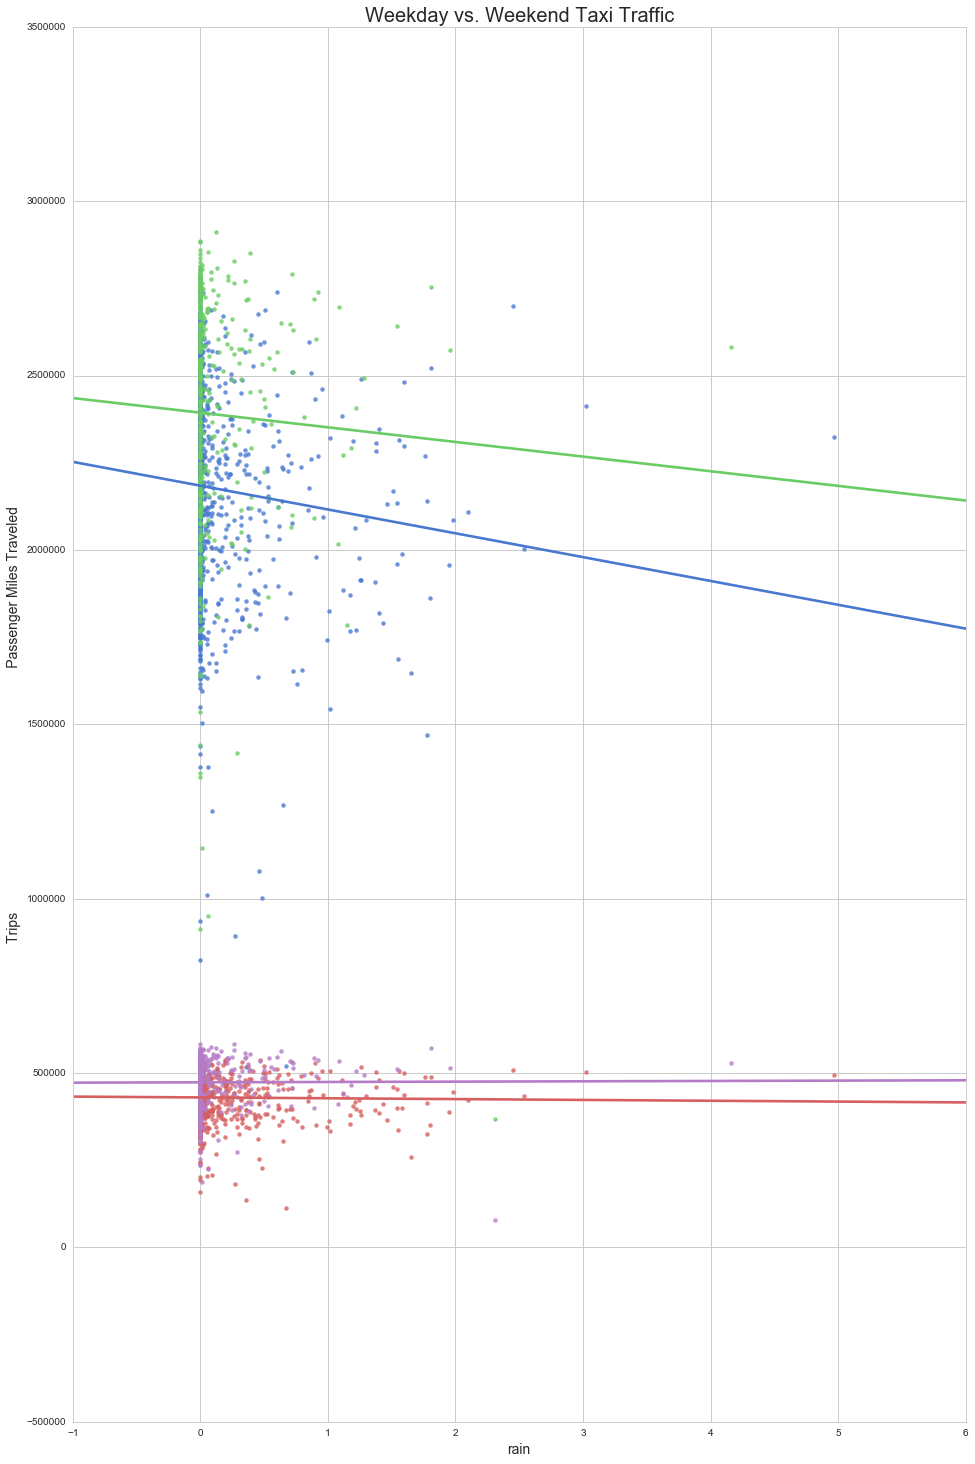

In [201]:
weekends = df[df.weekday>5]
weekdays = df[df.weekday<6]
sns.set_style("whitegrid")
sns.set_palette("muted")
plt.figure(figsize=(16,25))
plt.title("Weekday vs. Weekend Taxi Traffic", fontsize=20)
sns.regplot(weekdays.rain, weekdays.pmt,  ci=None)
sns.regplot(weekends.rain, weekends.pmt,  ci=None)
sns.regplot(weekdays.rain, weekdays.trips,  ci=None)
sns.regplot(weekends.rain, weekends.trips,  ci=None)
plt.xlabel("rain", fontsize=14)
plt.ylabel("Trips                                                               Passenger Miles Traveled", fontsize=14)
plt.show()

### As we can see from this last plot, on weekends and weekdays the number of passenger miles trends downward with rain, while the number of trips in a given day remains stable as rain increases. 

In [11]:
weekends = df[df.weekend==1]
weekdays = df[df.weekend==0]
saturdays = df[df.weekday==6]
sundays = df[df.weekday==7]

In [60]:
import pandas as pd

from bokeh.charts import TimeSeries, show

data = dict(date=df.date, weekend=df.weekend, pmt=df.pmt, trips=df.trips)

tsplot = TimeSeries(data,
    x='date', y=['pmt', 'trips'],
    color=['blue','green'],
    title="Timeseries of PMT and Trips", marker='weekend',
    ylabel='Values', builder_type= "line", legend=True, plot_width=800)

output_notebook()
show(tsplot)

Loading BokehJS ...

## The amount of room between the CDFs suggests that weekend and weekday traffic should be treated as separate samples. 
## pmt and trips are almost perfectly normally distributed and highly correlated. 

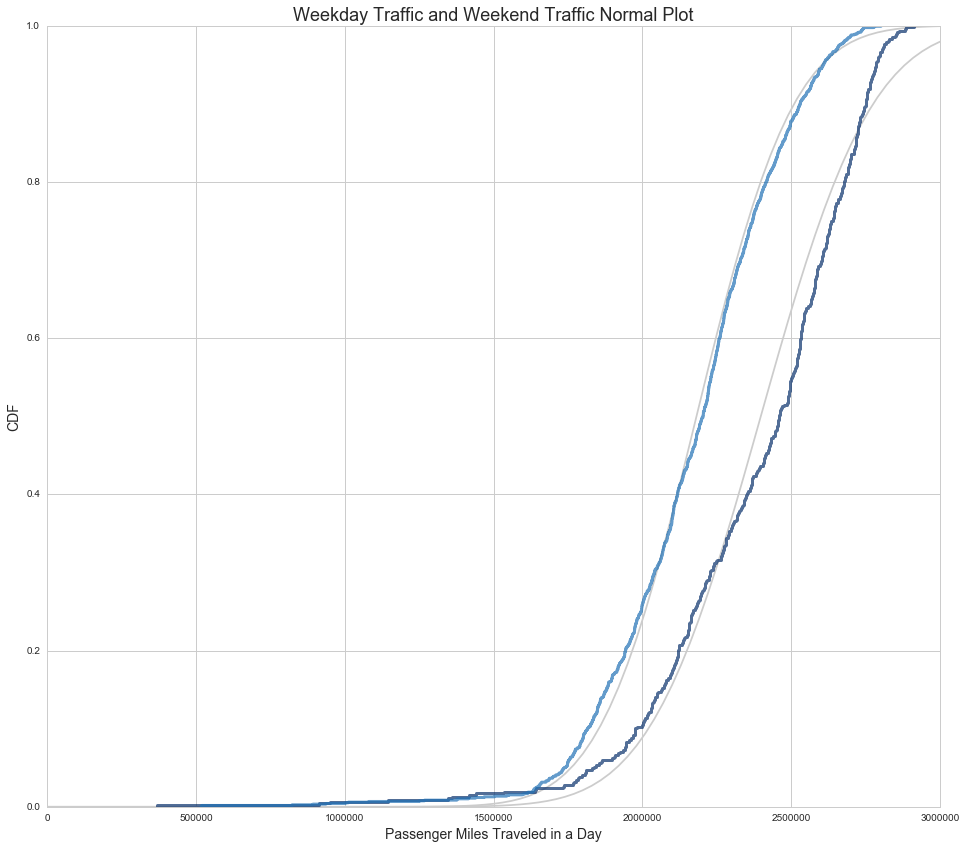

In [71]:
data1 = weekdays.pmt
mu1, var1 = ts2.TrimmedMeanVar(data1, p=0.01)

data2 = weekends.pmt
mu2, var2 = ts2.TrimmedMeanVar(data2, p=0.01)

# plot the models
sigma1 = math.sqrt(var1)
xs1, ps1 = ts2.RenderNormalCdf(mu1, sigma1, low=0, high=3000000)
weekday_cdf = ts2.Cdf(data1)

sigma2 = math.sqrt(var2)
xs2, ps2 = ts2.RenderNormalCdf(mu2, sigma2, low=0, high=3000000)
weekend_cdf = ts2.Cdf(data2)

plt.figure(figsize=(16,14))
plt.plot(xs1, ps1, color='0.8')
plt.plot(xs2, ps2, color='0.8')

#parameters for the resulting graph:
plt.title("Weekday Traffic and Weekend Traffic Normal Plot", fontsize=18)
plt.xlabel("Passenger Miles Traveled in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(weekend_cdf)
tp.Cdf(weekday_cdf)
plt.show()

## Feature Selection: 
### I've transformed the data to include the number of passenger miles traveled per day i.e. (Σ(number of passengers per trip*length of trip)) as well as a simple count of trips per day. It would be useful to understand how similar are the two metrics.

### Checking the Pearson's Correlation between PMT and trips

In [18]:
pmt_frame = df[df.pmt>0]
data = pmt_frame.pmt, pmt_frame.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(pmt_frame.pmt, pmt_frame.trips)
print(correlation)
print(pvalue)

0.886641963833
0.0


### I was unsure whether normalizing the values would influence the result of the Pearson's correlation.

In [19]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
scaled_trips = min_max_scaler.fit_transform(df.trips)
scaled_pmt = min_max_scaler.fit_transform(df.pmt)

C:\Users\Jay Price\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Jay Price\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Jay Price\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has 

In [20]:
from bokeh.charts import TimeSeries, show

data = dict(trips=scaled_trips, pmt=scaled_pmt, date=df.date)

tsline = TimeSeries(data,
    x='date', y=['trips','pmt'],
    color=['blue', 'green'],
    title="PMT vs Trips", ylabel='Passenger Miles Traveled', legend=True, plot_width=1000)

show(tsline)

### It turns out that checking the Pearson's Correlation on Normalized Values Gives Exactly the Same Answer.

In [21]:
data = scaled_pmt, scaled_trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(scaled_pmt, scaled_trips)
print(correlation)
print(pvalue)

0.886641963833
0.0


## Plot the time series for weekend and weekday traffic along with the means
### It becomes clear that weekend values are consistently higher than weekday values. With more tests, it could make sense to look at them as two separate samples.

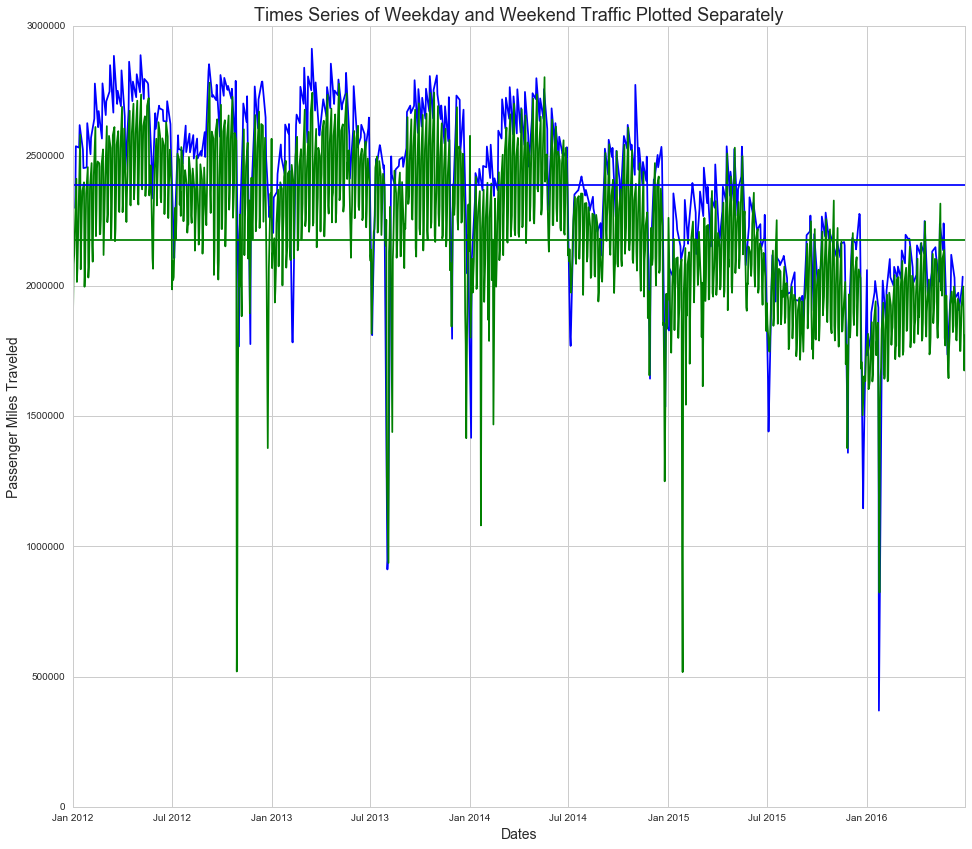

In [22]:
fig = plt.figure(figsize=(16,14))
plt.plot_date(weekends.date, weekends.pmt, 'b-')
plt.plot_date(weekdays.date, weekdays.pmt, 'g-')
plt.axhline(y=weekends.pmt.mean(), color='blue', linestyle='-')
plt.axhline(y=weekdays.pmt.mean(), color='green', linestyle='-')
plt.title("Times Series of Weekday and Weekend Traffic Plotted Separately", fontsize=18)
plt.xlabel("Dates", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.show()

fig.autofmt_xdate()

# Hypothesis
## There is a statistically significant difference between the sample of entries from weekday and weekend traffic.
### Step 1: Check whether the difference between the means of the samples is statistically signficant.
### Check both metrics: pmt and trips
### Null Hypothesis: The factors affecting both samples are the same; treating them as one sample should not result in different means.

In [23]:
weekends = df[df.weekend==1]
weekdays = df[df.weekend==0]
saturdays = df[df.weekday==6]
sundays = df[df.weekday==7]

In [223]:
data = weekends.pmt, weekdays.pmt
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = weekdays.pmt.mean()-weekends.pmt.mean()
print(difference_in_means)
print(pvalue)

-213009.42817966873
0.0


In [202]:
data = weekends.trips, weekdays.trips
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = weekdays.trips.mean()-weekends.trips.mean()
print(difference_in_means)
print(pvalue)

-43750.96880705585
0.0


In [27]:
data = saturdays.pmt, sundays.pmt
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(saturdays.pmt.mean()-sundays.pmt.mean())
print(difference_in_means)
print(pvalue)

56986.30769230751
0.059


In [28]:
data = saturdays.trips, sundays.trips
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(saturdays.trips.mean()-sundays.pmt.mean())
print(difference_in_means)
print(pvalue)

1944734.6965811965
0.785


# Hypothesis
## There is a statistically significant correlation between the amount of rain and yellow taxi traffic.

### Checking the Pearson's correlation between rainfall and weekend taxi traffic.

In [203]:
weekend_pmt = weekends.dropna(subset=['rain', 'pmt'])
data = weekend_pmt.rain, weekend_pmt.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = abs(ts2.Corr(weekend_pmt.rain, weekend_pmt.pmt))
print(correlation)
print(pvalue)

0.0419566169949
0.374


In [30]:
weekend_trips = weekends.dropna(subset=['rain', 'trips'])
data = weekend_trips.rain, weekend_trips.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = abs(ts2.Corr(weekend_pmt.rain, weekend_pmt.trips))
print(correlation)
print(pvalue)

0.00457505504644
0.921


### Although there's no statistically significant correlation between weekend trips or passenger miles traveled and the amount of rain, it makes sense to split the data between Saturdays and Sundays.
### What if we check the correlation separately for Saturdays and Sundays?

### Saturdays:

In [206]:
data = saturdays.rain, saturdays.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(saturdays.rain, saturdays.pmt)
print(correlation)
print(pvalue)

0.067523299609
0.307


In [208]:
data = saturdays.rain, saturdays.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = abs(ts2.Corr(saturdays.rain, saturdays.trips))
print(correlation)
print(pvalue)

0.100764719794
0.115


### Sundays:

In [204]:
data = sundays.rain, sundays.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(sundays.rain, sundays.pmt)
print(correlation)
print(pvalue)

-0.175939782859
0.005


In [209]:
data = sundays.rain, sundays.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(sundays.rain, sundays.trips)
print(correlation)
print(pvalue)

-0.116794180586
0.078


### There is a statistically significant correlation between passenger miles traveled and rain, but not between trips and rain. So that's the metric I will continue to examine.

### Checking the Pearson's correlation between rainfall and weekday traffic:

In [35]:
weekdays = df[df.weekend==0]
data = weekdays.rain, weekdays.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(weekdays.rain, weekdays.pmt)
print(correlation)
print(pvalue)

-0.0848779145667
0.005


In [210]:
data = weekdays.rain, weekdays.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(weekdays.rain, weekdays.trips)
print(correlation)
print(pvalue)

-0.0141014612457
0.64


### There is a statistically significant correlation between passenger miles traveled and rain, while the relationship does not exist for trips. This reinforces the idea that pmt is the best metric to examine.

## So Let's plot Taxi traffic against rainfall for weekdays and for Sundays:

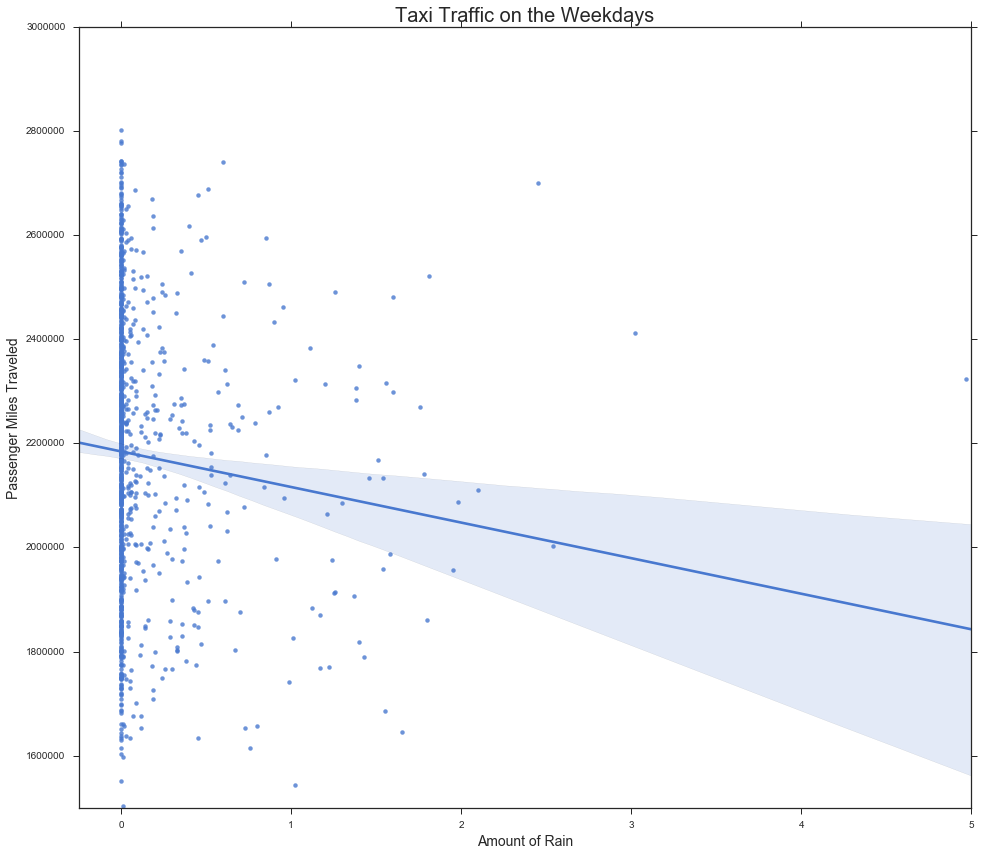

In [37]:
weekends = df[df.weekday<6]
x1 = weekdays.rain
y1 = weekdays.pmt

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=90)
plt.title("Taxi Traffic on the Weekdays", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.axis([-0.25, 5, 1500000, 3000000])
plt.show()

### When we look only at Sundays, we have about 1/5 as many data points. Therefore, in order to say that passenger miles traveled are decreasing we must reduce the confidence interval.

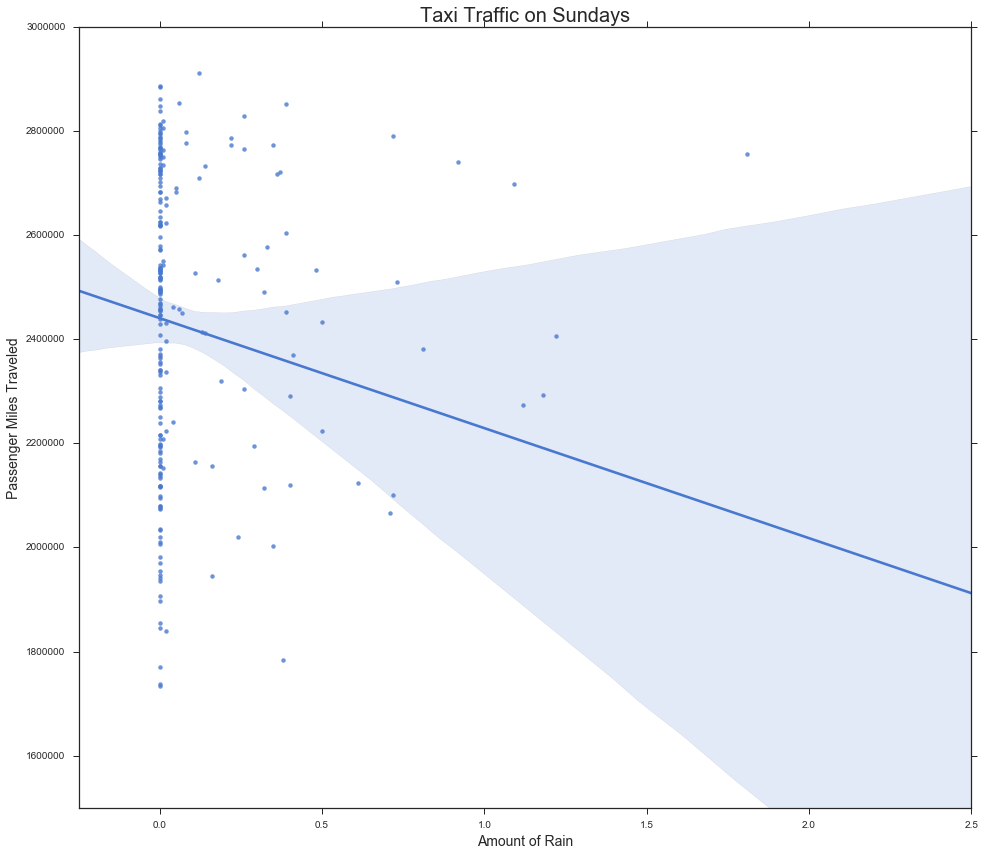

In [207]:
x1 = sundays.rain
y1 = sundays.pmt

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=90)
plt.title("Taxi Traffic on Sundays", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.axis([-0.25, 2.5, 1500000, 3000000])
plt.show()

### We can try to correct for measurement error or sampling bias by plotting the linear regression for a number of samples after resampling with replacement.

In [241]:
def SamplingDistributions(data, iters=101):
    t = [] 
    for _ in range(iters):
        sample = ts2.ResampleRows(data)
        rain = sample.rain
        pmt = sample.pmt
        estimates = ts2.LeastSquares(rain, pmt)
        t.append(estimates)
    
    inters, slopes = zip(*t)
    return inters, slopes, estimates

def Summarize(estimates, actual=None):
    mean = ts2.Mean(estimates)
    stderr = ts2.Std(estimates, mu=actual)
    cdf = ts2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('Mean: ', mean)
    print('Standard Error: ', stderr)
    print('Confidence Interval: ', ci )

def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    plt.figure(figsize=(16,14))
    plt.title("90 Percent Confidence for Weekday Taxi Traffic", fontsize=20)
    plt.xlabel("Rain in Inches", fontsize=14)
    plt.ylabel("Passenger Miles Traveled", fontsize=14)
    plt.axis([-0.25, 5, 1400000, 2400000])
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = ts2.FitLine(xs, inter, slope)
        fys_seq.append(fys)
    
    p = (100-percent) / 2
    percents = p, 100-p
    low, high = ts2.PercentileRows(fys_seq, percents)
    tp.FillBetween(fxs, low, high, **options)
    weekends = df[df.weekday<6]
    x1 = weekdays.rain
    y1 = weekdays.pmt
    fit1 = np.polyfit(x1, y1, deg=1)
    plt.plot(x1, fit1[0] * x1 + fit1[1], color='red')
    tp.Show()

In [235]:
inters, slopes, estimates = SamplingDistributions(weekdays)

In [236]:
Summarize(estimates)

Mean:  1028933.16063
Standard Error:  1148821.7261883689
Confidence Interval:  (-119888.56556083103, 2177754.8868159065)


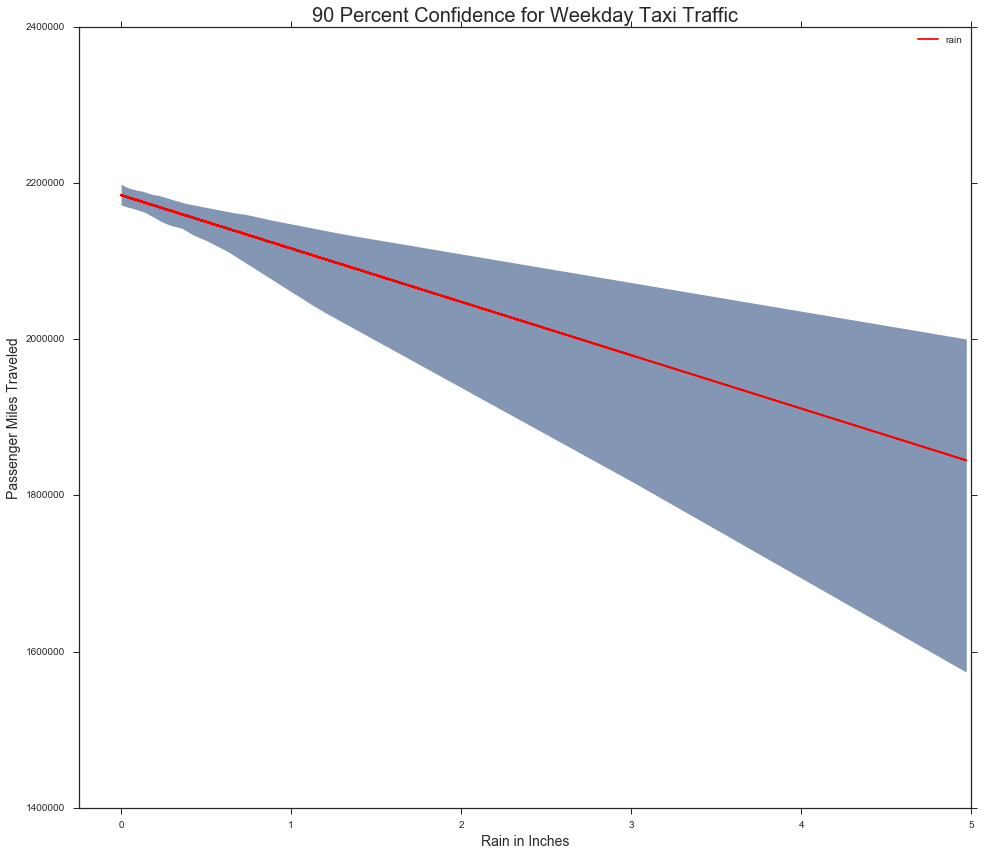

In [237]:
PlotConfidenceIntervals(weekdays.rain, inters, slopes, percent=90)

In [253]:
class SlopeTest(ts2.HypothesisTest):
    def TestStatistic(self, data):
        rain, pmt = data
        _, slope = ts2.LeastSquares(rain, pmt)
        return abs(slope)
    
    def MakeModel(self):
        _, pmt = self.data
        self.ybar = pmt.mean()
        self.res = pmt - self.ybar
        
    def RunModel(self):
        rain, _ = self.data
        pmt = self.ybar + np.random.permutation(self.res)
        return rain, pmt

In [256]:
ht = SlopeTest((sundays.rain, sundays.pmt)1)
pvalue = ht.PValue()
print(pvalue)

TypeError: __init__() got an unexpected keyword argument 'iters'

In [255]:
inters, slopes, estimates = SamplingDistributions(weekdays, iters=1001)
slope_cdf = ts2.Cdf(slopes)
pvalue = slope_cdf[0]
print(pvalue)

0.999000999001


In [45]:
mta = dataframe[dataframe.entries>0]
len(mta)

952

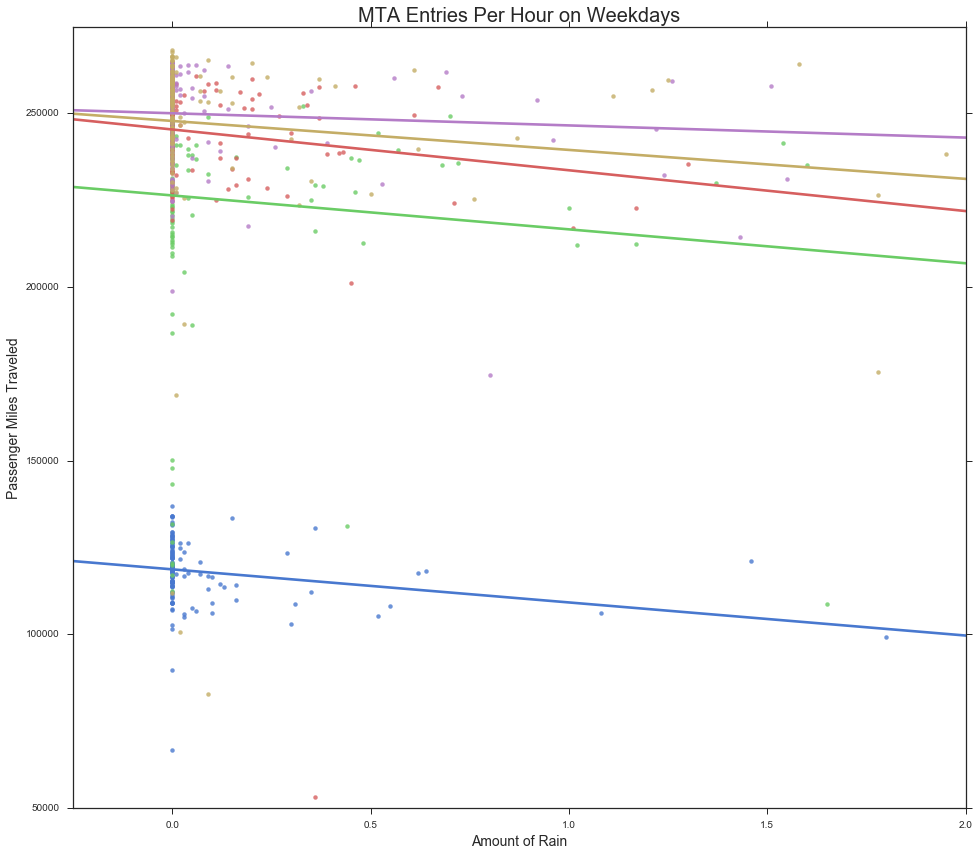

In [46]:
x1 = mta[mta.weekday==1].rain
y1 = mta[mta.weekday==1].entries
x2 = mta[mta.weekday==2].rain
y2 = mta[mta.weekday==2].entries
x3 = mta[mta.weekday==3].rain
y3 = mta[mta.weekday==3].entries
x4 = mta[mta.weekday==4].rain
y4 = mta[mta.weekday==4].entries
x5 = mta[mta.weekday==5].rain
y5 = mta[mta.weekday==5].entries

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=None, label="Mondays")
sns.regplot(x2, y2, ci=None, label="Tuesdays")
sns.regplot(x3, y3, ci=None, label="Wednesdays")
sns.regplot(x4, y4, ci=None, label="Thursdays")
sns.regplot(x5, y5, ci=None, label="Fridays")
plt.title("MTA Entries Per Hour on Weekdays", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Passenger Miles Traveled", fontsize=14)
plt.axis([-0.25, 2, 50000, 275000])
plt.show()

Blue = Mondays, Green = Tuesday, Red = Wednesdays, Purple = Thursdays, Yellow = Friday

### We can check how likely it is that we would end up with such a different mean for traffic on Mondays by chance.

In [47]:
mondays = mta[mta.weekday==1].entries
other_weekdays = mta[(mta.weekend==0)&(mta.weekday!=1)].entries
data = mondays, other_weekdays
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(mondays.mean()-other_weekdays.mean())
print(difference_in_means)
print(pvalue)

123488.45768277561
0.0


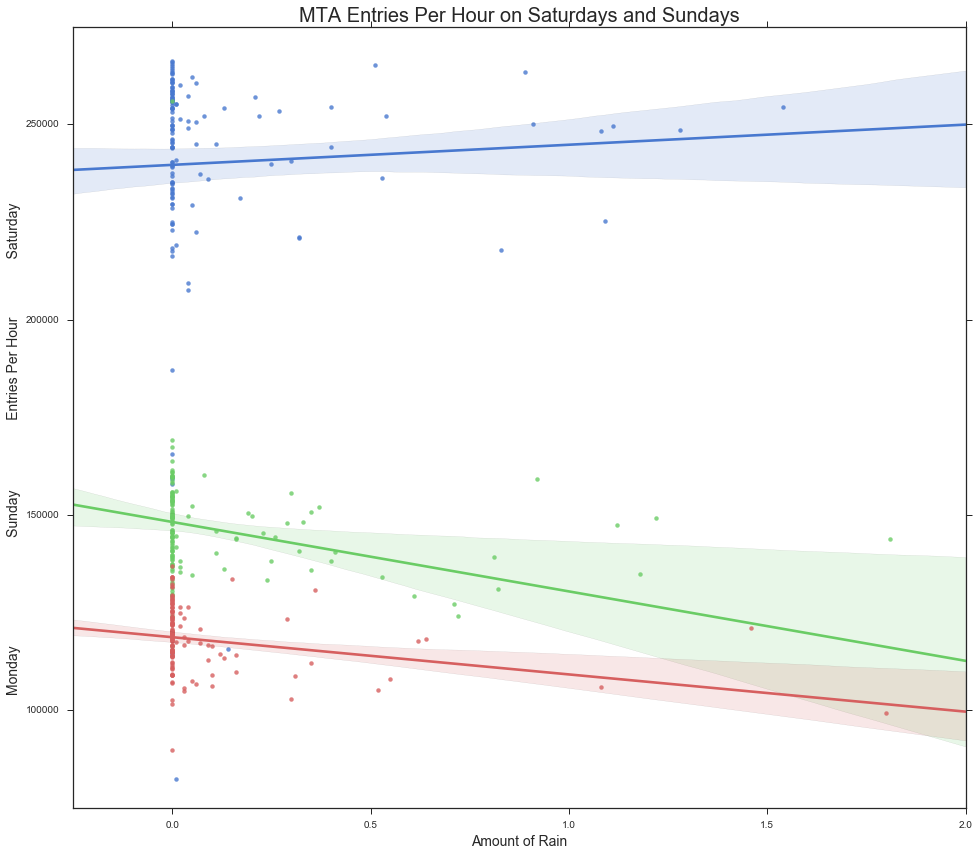

In [48]:
x1 = mta[mta.weekday==6].rain
y1 = mta[mta.weekday==6].entries
x2 = mta[mta.weekday==7].rain
y2 = mta[mta.weekday==7].entries
x3 = mta[mta.weekday==1].rain
y3 = mta[mta.weekday==1].entries

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=90, label="Saturdays")
sns.regplot(x2, y2, ci=90, label="Sundays")
sns.regplot(x3, y3, ci=90, label="Mondays")
plt.title("MTA Entries Per Hour on Saturdays and Sundays", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Monday                            Sunday                  Entries Per Hour               Saturday                ", fontsize=14)
plt.axis([-0.25, 2, 75000, 275000])
plt.show()

In [49]:
data = y1, y2
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(y1.mean()-y2.mean())
print(difference_in_means)
print(pvalue)

94347.67704852947
0.0


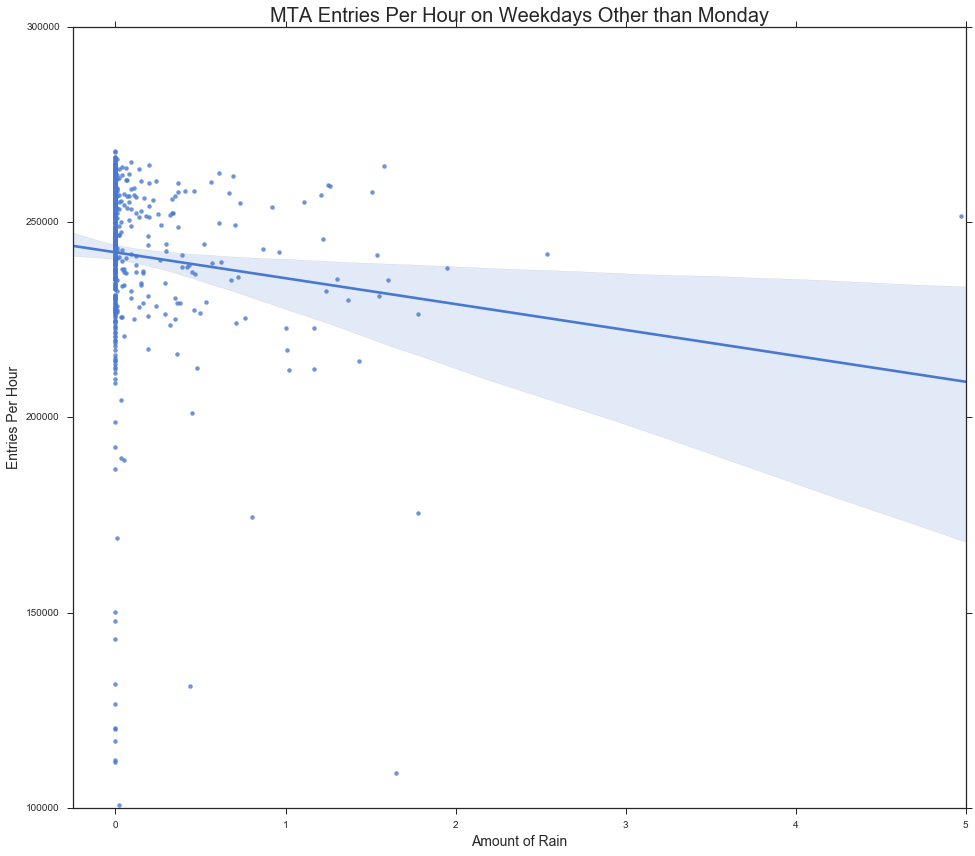

In [50]:
other_weekdays = mta[(mta.weekend==0)&(mta.weekday!=1)]
x1 = other_weekdays.rain
y1 = other_weekdays.entries

plt.figure(figsize=(16,14))
sns.set_palette("muted")
sns.set_style("ticks")
sns.regplot(x1, y1, ci=90, label="Saturdays")
plt.title("MTA Entries Per Hour on Weekdays Other than Monday", fontsize=20)
plt.xlabel("Amount of Rain", fontsize=14)
plt.ylabel("Entries Per Hour", fontsize=14)
plt.axis([-0.25, 5, 100000, 300000])
plt.show()


In [51]:
frame = mta[(mta.pmt>0)&(mta.entries>0)]
data = frame.pmt, frame.entries
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(frame.pmt, frame.entries)
print(correlation)
print(pvalue)

-0.0883777070532
0.009


In [52]:
frame = mta[(mta.trips>0)&(mta.entries>0)]
data = frame.trips, frame.entries
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(frame.trips, frame.entries)
print(correlation)
print(pvalue)
frame.head()

0.206760033411
0.0


,date,rain,snowdepth,snow,weekday,weekend,holidays,trips,pmt,entries
762,2014-02-01,0.00,1.2,0.0,7,1,0,530995.0,2535656.0,137358.7917
763,2014-02-02,0.00,1.2,0.0,1,0,0,461620.0,2396314.0,114924.0000
764,2014-02-03,1.17,1.2,8.0,2,0,0,380171.0,1870718.0,212375.3750
765,2014-02-04,0.00,7.9,0.0,3,0,0,452090.0,2099456.0,251517.1667
766,2014-02-05,1.43,9.1,4.0,4,0,0,411801.0,1789050.0,214415.3333


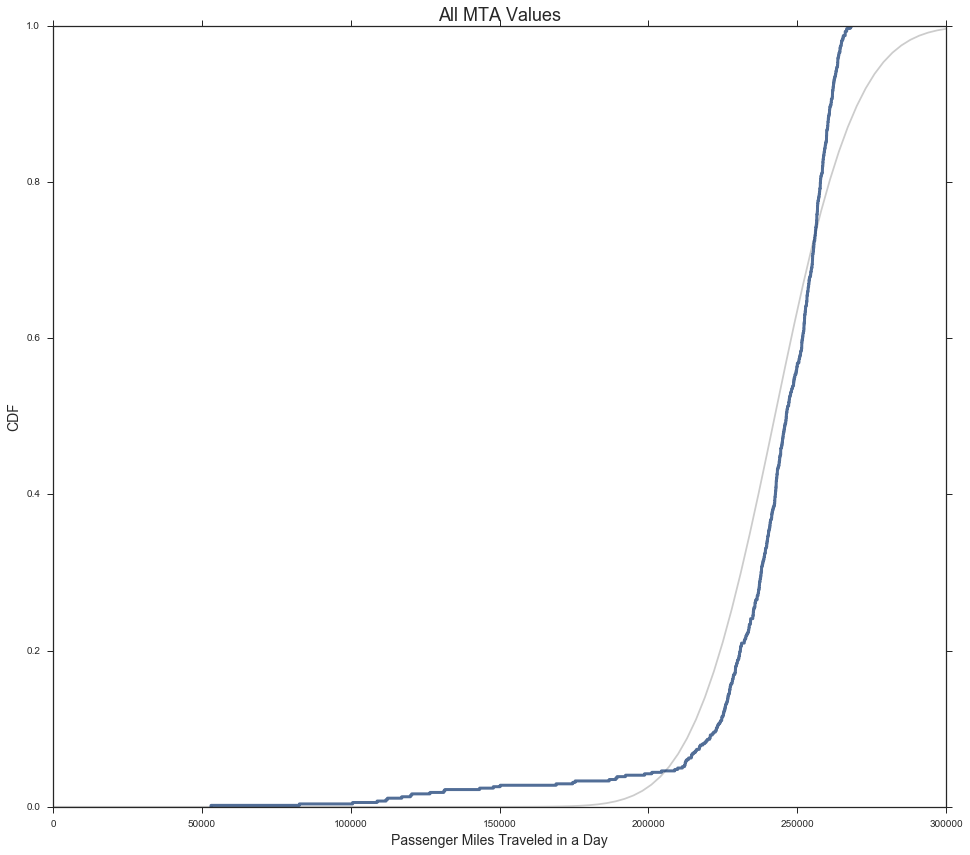

In [53]:
data = mta[(mta.weekend==0)&(mta.weekday!=1)].entries
mu, var = ts2.TrimmedMeanVar(data, p=0.01)

# plot the model
sigma = math.sqrt(var)
xs, ps = ts2.RenderNormalCdf(mu, sigma, low=0, high=300000)
cdf = ts2.Cdf(data)

plt.figure(figsize=(16,14))
plt.plot(xs, ps, color='0.8')
#parameters for the resulting graph:
plt.title("All MTA Values", fontsize=18)
plt.xlabel("Passenger Miles Traveled in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(cdf)
plt.show()

In [54]:
weekdays = mta.entries
mta_hist = Histogram(weekdays, values='entries', legend='bottom_left', bins=50,
                  title="Histogram for Weekday MTA Entries", plot_width=1000)

show(mta_hist)

In [55]:
frame = mta[(mta.pmt>0)&(mta.entries>0)]
for i in range(1,7): 
    particular_day = frame[frame.weekday==i]
    data = particular_day.pmt, particular_day.entries
    ht = CorrelationPermuate(data)
    pvalue = ht.PValue()
    correlation = ts2.Corr(particular_day.pmt, particular_day.entries)
    print(correlation)
    print(pvalue)

0.585676400196
0.0
0.189435043788
0.046
0.613677896003
0.0
0.350775848236
0.001
0.500654155299
0.0
0.565129164437
0.0


In [56]:
frame = mta[(mta.trips>0)&(mta.entries>0)]
for i in range(1,7): 
    particular_day = frame[frame.weekday==i]
    data = particular_day.trips, particular_day.entries
    ht = CorrelationPermuate(data)
    pvalue = ht.PValue()
    correlation = ts2.Corr(particular_day.trips, particular_day.entries)
    print(correlation)
    print(pvalue)

0.354292086645
0.0
0.443125223355
0.0
0.617178828098
0.0
0.329728895661
0.0
0.594093228128
0.0
0.64626470472
0.0
